# **Problem statement:**

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

## Importing all the important libraries

In [1]:
#import libraries

import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
# mount google drive.
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Unzip the dataset
!unzip "/content/gdrive/MyDrive/CNN_assignment.zip" > /dev/null

There are 2,357 images in the dataset showcasing various types of skin cancer. Within both the train and test subdirectories, there are 9 subfolders, each for one of the 9 distinct skin cancer types, containing relevant images.

In [4]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

In [5]:
# Get the count of the number of images in the Train and Test directories
# Using the glob to retrieve files/pathnames matching a specified pattern.

# Train Image count
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print('Train image count:\t', image_count_train)

#Test Image count
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print('Test image count:\t', image_count_test)

Train image count:	 2239
Test image count:	 118


# **Create a dataset**

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Using 80% of the images for training(train_ds) and 20% for validation(val_ds)

In [7]:
#Train datset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    batch_size=batch_size,
    image_size=(img_height,img_width),
    label_mode='categorical',
    seed=123,
    subset="training",
    validation_split=0.2)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
#Validation Dataset
val_ds =tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    batch_size=batch_size,
    image_size=(img_height,img_width),
    label_mode='categorical',
    seed=123,
    subset="validation",
    validation_split=0.2)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# Listing out all the classes of skin cancer and store them in a list.

class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


# Visualize the data

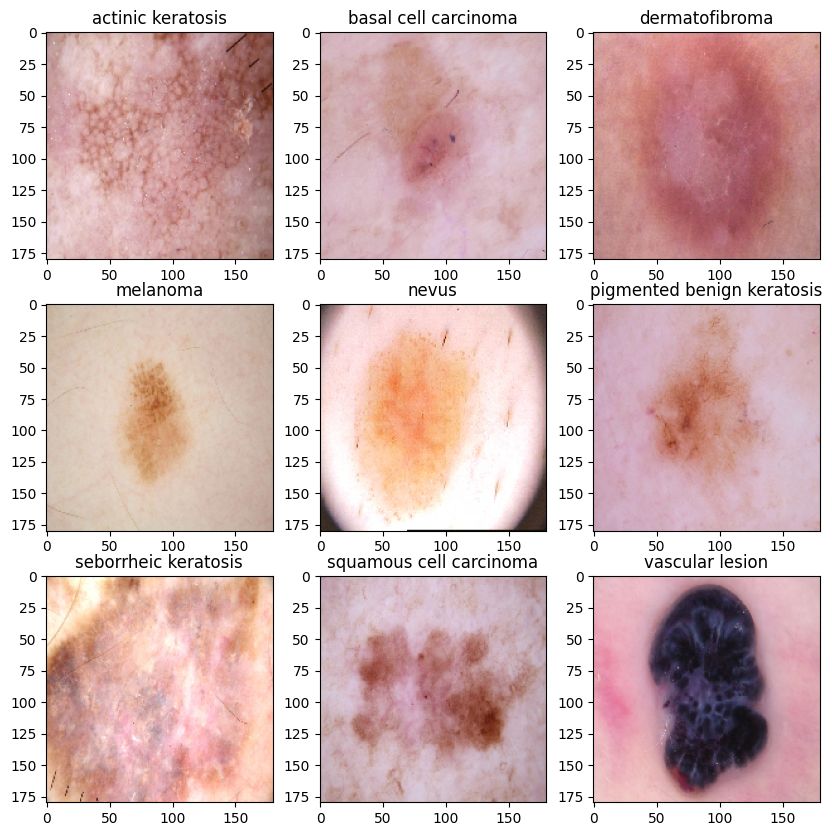

In [10]:
from tensorflow.keras.preprocessing.image import load_img

#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))

#Visualize image
plt.figure(figsize=(10,10))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(img_height,img_width)))
    plt.title(c)

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# **1st Itteration:**

# Create the model

In [12]:
from keras.layers import Conv2D
model = Sequential()    # Sequential() creates model layer by layer

#First Convolution Layer
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height,img_width,3)))
model.add(layers.Conv2D(16, 3, padding='same', activation='relu'))
model.add(layers.MaxPool2D())

# Second convolution layer
model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(layers.MaxPool2D())

# Third convolution layer
model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(layers.MaxPool2D())

model.add(layers.Flatten())   #flatten function converts the multi-dimensional input tensors into a single dimension array

# Dense layer 1
model.add(layers.Dense(128, activation='relu'))

# Dense layer 2
model.add(layers.Dense(64, activation='relu'))

#Dense Layer with softmax activation function.
model.add(layers.Dense(9, activation='softmax'))     #this will classify the input into 9 classes based on probability

# Compile the model

In [13]:
model.compile(
    optimizer='Adam',
    loss="categorical_crossentropy",
    metrics=['accuracy'])

In [14]:
# Summary of the model created
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

# Train the model

In [15]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 28s 115ms/step - loss: 1.9477 - accuracy: 0.2640 - val_loss: 1.7260 - val_accuracy: 0.3579
Epoch 2/20
56/56 [==============================] - 2s 33ms/step - loss: 1.6628 - accuracy: 0.3901 - val_loss: 1.5179 - val_accuracy: 0.4720
Epoch 3/20
56/56 [==============================] - 1s 21ms/step - loss: 1.4434 - accuracy: 0.5022 - val_loss: 1.3785 - val_accuracy: 0.5257
Epoch 4/20
56/56 [==============================] - 1s 21ms/step - loss: 1.4053 - accuracy: 0.5061 - val_loss: 1.4736 - val_accuracy: 0.4474
Epoch 5/20
56/56 [==============================] - 1s 21ms/step - loss: 1.2702 - accuracy: 0.5541 - val_loss: 1.3477 - val_accuracy: 0.5436
Epoch 6/20
56/56 [==============================] - 1s 21ms/step - loss: 1.2093 - accuracy: 0.5826 - val_loss: 1.4024 - val_accuracy: 0.5324
Epoch 7/20
56/56 [==============================] - 1s 21ms/step - loss: 1.1090 - accuracy: 0.5960 - val_loss: 1.3581 - val_accuracy: 0.5414
Epoch 8/20


# Visualizing training results

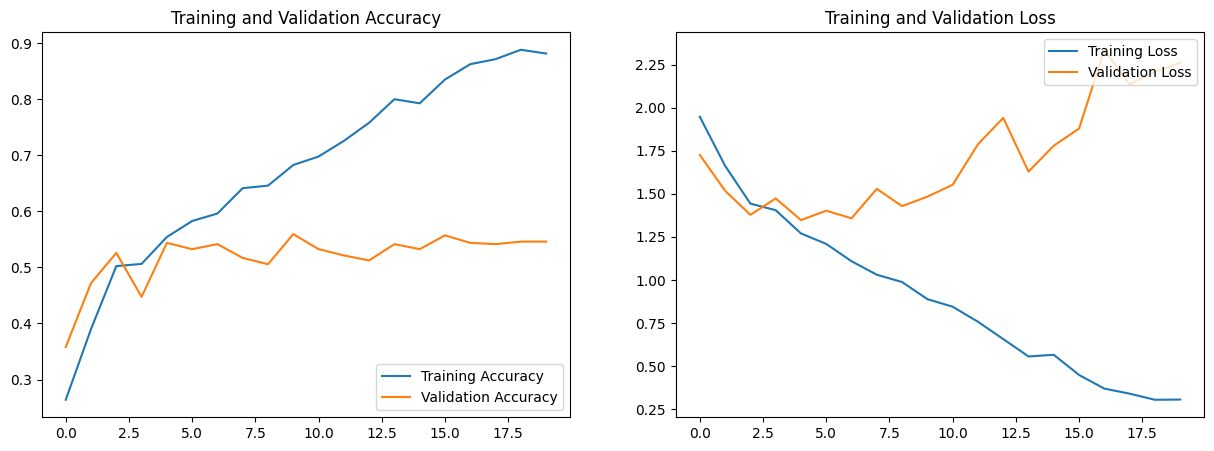

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Visualizing the data, it is clearly visible that the model has a tremendous 'Overfitting' problem. The training accuracy increases to a high level(around 85%) while the Validation accuracy stablises at around 50%

# **2nd Itteration:**

# **Data Augumentation**

In [17]:
data_aug = keras.Sequential(
    [
        #Randomly flip each image horizontally and vertically.
        layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", input_shape=(img_height, img_width, 3)),

        #Randomly rotate each image.
        layers.experimental.preprocessing.RandomRotation(0.2),

        #Randomly zoom each image during training.
        layers.experimental.preprocessing.RandomZoom(0.2),
    ])

## Visualizing the augmentation image

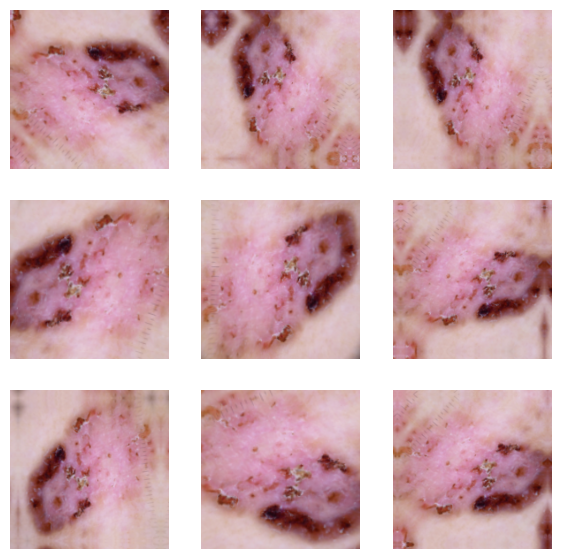

In [18]:
plt.figure(figsize=(7, 7))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_aug(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

Creating a model again using the augumentation method to see the effects on model performance.


# Create the model

In [19]:
from keras.layers import Conv2D
model = Sequential()    # Sequential() creates model layer by layer

# Augumentation layer
model.add(data_aug)

#First Convolution Layer
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height,img_width,3)))
model.add(layers.Conv2D(16, 3, padding='same', activation='relu'))
model.add(layers.MaxPool2D())

# Second convolution layer
model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(layers.MaxPool2D())

# Third convolution layer
model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(layers.MaxPool2D())

model.add(layers.Flatten())   #flatten function converts the multi-dimensional input tensors into a single dimension array

# Dense layer 1
model.add(layers.Dense(128, activation='relu'))

# Dense layer 2
model.add(layers.Dense(64, activation='relu'))

#Dense Layer with softmax activation function.
model.add(layers.Dense(9, activation='softmax'))     #this will classify the input into 9 classes based on probability

## Compile the model

In [20]:
model.compile(
    optimizer='Adam',
    loss="categorical_crossentropy",
    metrics=['accuracy'])

In [21]:
# Summary of the model created
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

## Train the model

In [22]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 4s 29ms/step - loss: 2.0237 - accuracy: 0.2405 - val_loss: 1.8800 - val_accuracy: 0.2998
Epoch 2/20
56/56 [==============================] - 1s 24ms/step - loss: 1.8084 - accuracy: 0.3253 - val_loss: 1.6614 - val_accuracy: 0.3870
Epoch 3/20
56/56 [==============================] - 1s 24ms/step - loss: 1.6567 - accuracy: 0.3934 - val_loss: 1.5000 - val_accuracy: 0.4810
Epoch 4/20
56/56 [==============================] - 1s 24ms/step - loss: 1.4841 - accuracy: 0.4866 - val_loss: 1.5036 - val_accuracy: 0.4810
Epoch 5/20
56/56 [==============================] - 1s 27ms/step - loss: 1.4362 - accuracy: 0.4967 - val_loss: 1.4426 - val_accuracy: 0.5168
Epoch 6/20
56/56 [==============================] - 2s 27ms/step - loss: 1.4201 - accuracy: 0.4944 - val_loss: 1.4828 - val_accuracy: 0.4944
Epoch 7/20
56/56 [==============================] - 1s 24ms/step - loss: 1.3590 - accuracy: 0.5251 - val_loss: 1.4053 - val_accuracy: 0.5034
Epoch 8/20
56

## Visualizing training results

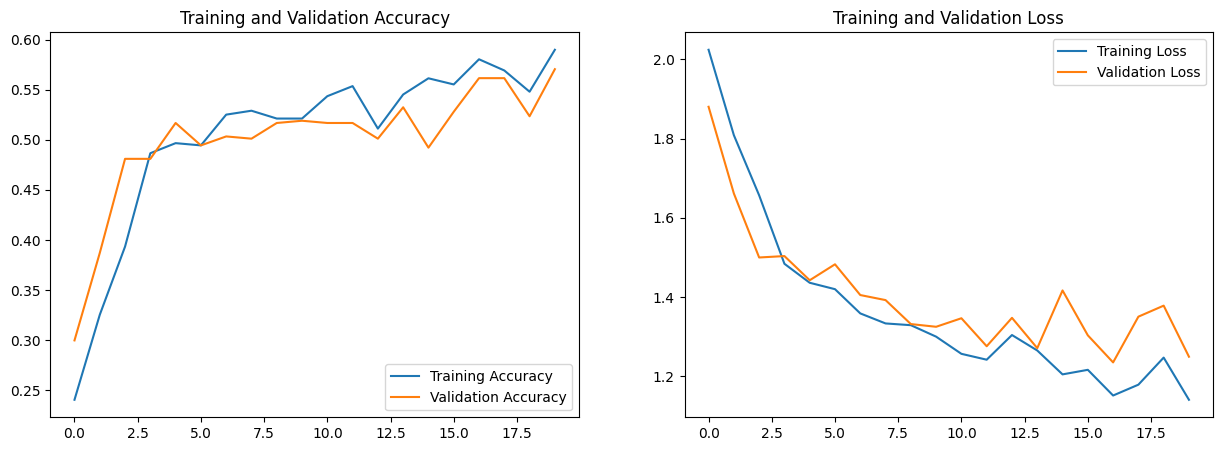

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()



*   Augumentation had a profound effect on the model. The problem of overfitting appears to be resolved.
*   However, the Training an Validation accuracies are not so high. So now the model seems to be underfitting.



# **3rd Itteration:**

## Handling class imbalances

Context: Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [24]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)

2239

In [25]:
df_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(df_dict_original.items()), columns = ('Path', 'Label'))
original_df

,Path,Label
0,/content/Skin cancer ISIC The International Sk...,melanoma
1,/content/Skin cancer ISIC The International Sk...,melanoma
2,/content/Skin cancer ISIC The International Sk...,melanoma
3,/content/Skin cancer ISIC The International Sk...,melanoma
4,/content/Skin cancer ISIC The International Sk...,melanoma
...,...,...
2234,/content/Skin cancer ISIC The International Sk...,pigmented benign keratosis
2235,/content/Skin cancer ISIC The International Sk...,pigmented benign keratosis
2236,/content/Skin cancer ISIC The International Sk...,pigmented benign keratosis
2237,/content/Skin cancer ISIC The International Sk...,pigmented benign keratosis


Class=3, n=438 (19.562%)
Class=0, n=114 (5.092%)
Class=6, n=77 (3.439%)
Class=8, n=139 (6.208%)
Class=2, n=95 (4.243%)
Class=1, n=376 (16.793%)
Class=4, n=357 (15.945%)
Class=7, n=181 (8.084%)
Class=5, n=462 (20.634%)


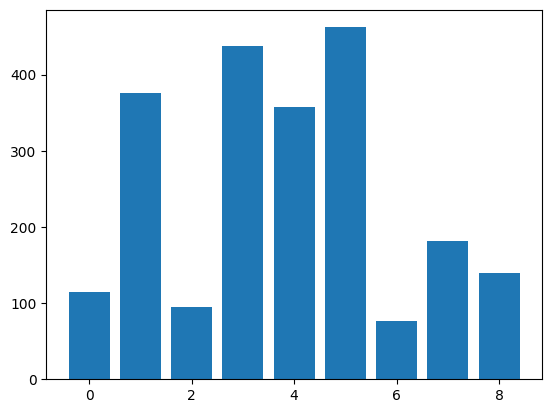

In [26]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter as i

# Biforcating into input and output
X,y = original_df['Path'], original_df['Label']

# Label encode y
y = LabelEncoder().fit_transform(y)

# Summarising
i = i(y)
for k,v in i.items():
  z = v/len(y) * 100
  print('Class=%d, n=%d (%.3f%%)' % (k, v, z))

# Plotting for visualisation
plt.bar(i.keys(), i.values())
plt.show()

*   Classes 5 and 3 are dominating the data in terms of number of samples at around 20%
*   Classes 2 and 6 have the least contribution at around 4% each.
*   This clearly shows that there is an imbalance amongst the contribution to data from the classes.

## Rectifying the class imbalance

In [27]:
!pip install Augmentor

In [28]:
path_to_training_dataset="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for a in class_names:
  p = Augmentor.Pipeline(path_to_training_dataset + a)
  p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
  p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C7F379F37C0>: 100%|██████████| 500/500 [00:17<00:00, 28.40 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C7F37A120E0>: 100%|██████████| 500/500 [00:21<00:00, 22.95 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C7FD0084190>: 100%|██████████| 500/500 [00:20<00:00, 24.14 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=722x542 at 0x7C7F34727100>: 100%|██████████| 500/500 [01:29<00:00,  5.61 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C7F3475CC10>: 100%|██████████| 500/500 [01:13<00:00,  6.78 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C7FEC0F7010>: 100%|██████████| 500/500 [00:15<00:00, 31.50 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7C7F3795A3E0>: 100%|██████████| 500/500 [00:38<00:00, 13.13 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C7FEC0F7010>: 100%|██████████| 500/500 [00:15<00:00, 32.80 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C7FDDFC2E00>: 100%|██████████| 500/500 [00:15<00:00, 31.89 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [29]:
#Count total number of images generated by Augmentor.
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


# Distribution of augmented data after adding new images to the original training data.

In [30]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*', 'output', '*.jpg'))]
path_list_new[:2]


['/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000172.jpg_cd37af63-6f7d-4943-8f8a-e701acd9f8dd.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000434.jpg_cf03345c-4fc0-4ea9-8e0a-5bed227511e3.jpg']

In [31]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new[:2]

['melanoma', 'melanoma']

In [32]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [33]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)
new_df.shape

<ipython-input-33-c1e5e8a551a2>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = original_df.append(df2)


(6739, 2)

In [34]:
new_df.head()

,Path,Label
0,/content/Skin cancer ISIC The International Sk...,melanoma
1,/content/Skin cancer ISIC The International Sk...,melanoma
2,/content/Skin cancer ISIC The International Sk...,melanoma
3,/content/Skin cancer ISIC The International Sk...,melanoma
4,/content/Skin cancer ISIC The International Sk...,melanoma


In [35]:
# Checking the class distribution after adding 500 samples per label
new_df['Label'].value_counts(normalize=True)

pigmented benign keratosis    0.142751
melanoma                      0.139190
basal cell carcinoma          0.129990
nevus                         0.127170
squamous cell carcinoma       0.101054
vascular lesion               0.094821
actinic keratosis             0.091111
dermatofibroma                0.088292
seborrheic keratosis          0.085621
Name: Label, dtype: float64

In [36]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

500 images added to all the classes to maintain class balance.

# Train the model on the data created using Augmentor

In [37]:
batch_size = 32
img_height = 180
img_width = 180

# Create a training dataset

In [38]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,seed=123,
    validation_split = 0.2,
    subset = 'training',
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


# Creating a validation dataset

In [39]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset = 'validation',
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


## Creating a model

In [59]:
model = Sequential()    # Sequential() creates model layer by layer

#First Convolution Layer
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height,img_width,3)))
model.add(layers.Conv2D(16, 3, padding='same', activation='relu'))
model.add(layers.MaxPool2D())

# Second convolution layer
model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(layers.MaxPool2D())

#Dropout layer
model.add(layers.Dropout(0.25))

# Third convolution layer
model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(layers.MaxPool2D())

model.add(layers.Flatten())   #flatten function converts the multi-dimensional input tensors into a single dimension array

# Dense layer 1
model.add(layers.Dense(128, activation='relu'))

#Dropout layer
model.add(layers.Dropout(0.25))

#Batch normalization: is a method used to make artificial neural networks faster and more stable through normalization of the layers' inputs by re-centering and re-scaling.
model.add(layers.BatchNormalization())

# Dense layer 2
model.add(layers.Dense(64, activation='relu'))

#Dense Layer with softmax activation function.
model.add(layers.Dense(9, activation='softmax'))     #this will classify the input into 9 classes based on probability

Adding dropout layers to improve model performance

# Compiling the model

In [60]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [61]:
# Model summary
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 90, 90, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 45, 45, 32)       

# Training the model

In [62]:
epochs = 30
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/30
169/169 [==============================] - 31s 152ms/step - loss: 1.9118 - accuracy: 0.2659 - val_loss: 1.9969 - val_accuracy: 0.2591
Epoch 2/30
169/169 [==============================] - 29s 166ms/step - loss: 1.5298 - accuracy: 0.4136 - val_loss: 2.2641 - val_accuracy: 0.2584
Epoch 3/30
169/169 [==============================] - 27s 153ms/step - loss: 1.4175 - accuracy: 0.4572 - val_loss: 1.2947 - val_accuracy: 0.5100
Epoch 4/30
169/169 [==============================] - 26s 149ms/step - loss: 1.3105 - accuracy: 0.5054 - val_loss: 1.2405 - val_accuracy: 0.5620
Epoch 5/30
169/169 [==============================] - 26s 152ms/step - loss: 1.2427 - accuracy: 0.5382 - val_loss: 1.2095 - val_accuracy: 0.5382
Epoch 6/30
169/169 [==============================] - 27s 153ms/step - loss: 1.2218 - accuracy: 0.5471 - val_loss: 1.3723 - val_accuracy: 0.4759
Epoch 7/30
169/169 [==============================] - 27s 148ms/step - loss: 1.1261 - accuracy: 0.5781 - val_loss: 1.0787 - val_ac

# Visualising training results

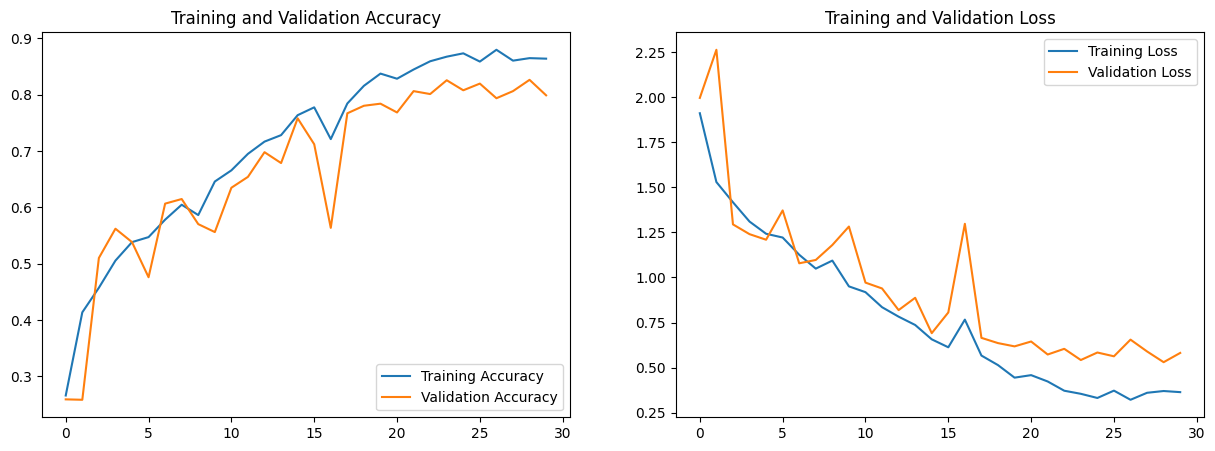

In [63]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

*   In the final model, there is no sign of underfitting/overfitting.
*   Class rebalance improved the model performance on both training and validation data.
*   In 30 epochs, the final model is able to achieve 86% training accuracy and 79% validation accuracy.
*   The low difference between the training accuracy and validation accuracy signifies that the final CNN model is able to generalize well.
*   Inclusion of batch normalization and dropout layers improved the accuracy of the final model.